The purpose of this notebook is to address all of the things that Reviewers 2/3 wanted

In [3]:
#set up the environment
library(reshape2)
library(tidyverse)
library(taigr) #useful for loading depmap data

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: RCurl


Attaching package: ‘RCurl’


The following object is masked from ‘package:tidyr’:

    complete


Loading required package: httr



# Comment 5 

The purpose of this code is to intersect the number of variants called by SNP array vs WGS

In [ ]:
###Bash code, just run this in terminal

#Get a list of all of the WGS and SNP6 samples
cd /home/jupyter/Ancestry/raw_data/depmap/wgs_data/
ls ACH*.vcf.gz | cut -d"." -f1 > /home/jupyter/Ancestry/analysis/wgs_snp6_intersection/wgs_file_names.txt

cd /home/jupyter/Ancestry/raw_data/depmap/snp6_data/
for file in split.all_chroms.maf.subset.reheader.ACH*.vcf.gz; do echo "${file%.vcf.gz}"; done > tmp.txt
sed 's/split\.all_chroms\.maf\.subset\.reheader\.//' tmp.txt > /home/jupyter/Ancestry/analysis/wgs_snp6_intersection/snp6_file_names.txt
rm tmp.txt

#Calculate the intersecting set of samples
cd /home/jupyter/Ancestry/analysis/wgs_snp6_intersection
file1="wgs_file_names.txt"  
file2="snp6_file_names.txt" 
comm -12 <(sort "$file1") <(sort "$file2") > intersecting_wgs_snp6_samples.txt


#Loop through all of the files and calculate the intersection
cd /home/jupyter/Ancestry/analysis/wgs_snp6_intersection
while IFS= read -r line; do
    echo "Processing line: $line"
	/home/jupyter/Ancestry/software/bcftools/bcftools isec /home/jupyter/Ancestry/raw_data/depmap/snp6_data/split.all_chroms.maf.subset.reheader.$line.vcf.gz /home/jupyter/Ancestry/raw_data/depmap/wgs_data/$line.pass.vcf.gz -p $line -Oz &
done < intersecting_wgs_snp6_samples.txt



#Create places to store the data
touch num_snp6_only.txt
touch num_wgs_only.txt
touch num_shared.txt


#Now loop through all of the output directories and record the number of variants for each file
for directory in /home/jupyter/Ancestry/analysis/wgs_snp6_intersection/ACH*/; do
    echo "Entering directory: $directory"
    cd "$directory"
	
	#Count the number of variants
	num_snp6_only=$(zcat 0000.vcf.gz | grep -v "#" | wc -l)
	num_wgs_only=$(zcat 0001.vcf.gz | grep -v "#" | wc -l)
	num_shared=$(zcat 0002.vcf.gz | grep -v "#" | wc -l)
	
	#Add this information to some new files
	echo $num_snp6_only >> /home/jupyter/Ancestry/analysis/wgs_snp6_intersection/num_snp6_only.txt
	echo $num_wgs_only >> /home/jupyter/Ancestry/analysis/wgs_snp6_intersection/num_wgs_only.txt
	echo $num_shared >> /home/jupyter/Ancestry/analysis/wgs_snp6_intersection/num_shared.txt
	
	#Leave the directory
    cd /home/jupyter/Ancestry/analysis/wgs_snp6_intersection/
	
done

In [2]:
#Load in the ancestry information for all of the cell lines
setwd('/home/jupyter/Ancestry/rfmix')
ancestry.calls = read.table("ccle_snp6_ancestry_calls.txt", sep = "\t", header = T) %>%
rename("sample" = 1, "afr" = 2, "amr" = 3, "eas" = 4, "eur" = 5, "sas" = 6) %>%
mutate("ancestry_call" = ifelse(afr >= 0.8, "afr",
                               ifelse(amr >= 0.8, "amr",
                                     ifelse(eas >= 0.8, "eas",
                                           ifelse(eur >= 0.8, "eur",
                                                 ifelse(sas >= 0.8, "sas", "admixed"))))))

head(ancestry.calls)

,sample,afr,amr,eas,eur,sas,ancestry_call
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ACH-000657,0.9601677273,0.0005504545,0.0063213636,0.03192409,0.0010363636,afr
2,ACH-000617,0.0028859091,0.0204050000,0.0000000000,0.97557545,0.0011336364,eur
3,ACH-000685,0.8539895455,0.0272740909,0.0395313636,0.07403591,0.0051686364,afr
4,ACH-000632,0.0025995455,0.0009922727,0.0001513636,0.99553364,0.0007231818,eur
5,ACH-000171,0.0007454545,0.0000000000,0.0010822727,0.99686682,0.0013054545,eur
6,ACH-000863,0.0065409091,0.0000000000,0.0036922727,0.96728000,0.0224868182,eur


In [7]:
#Load in the sample info
sample.info = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='sample_info')
head(sample.info)

msi.status = load.from.taiga(data.name='internal-23q2-1e49', data.version=95, data.file='OmicsSignatures') %>%
data.frame() %>%
rownames_to_column(var = "sample")
head(msi.status)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_sample-info.rds



,DepMap_ID,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,⋯,primary_disease,Subtype,age,Sanger_Model_ID,depmap_public_comments,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype,culture_type
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ACH-000001,NIH:OVCAR-3,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933,Female,ATCC,CVCL_0465,2201,⋯,Ovarian Cancer,"Adenocarcinoma, high grade serous",60,SIDM00105,,ovary,ovary_adenocarcinoma,high_grade_serous,,Adherent
2,ACH-000002,HL-60,HL60,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,,905938,Female,ATCC,CVCL_0002,55,⋯,Leukemia,"Acute Myelogenous Leukemia (AML), M3 (Promyelocytic)",35,SIDM00829,,blood,AML,M3,,Suspension
3,ACH-000003,CACO2,CACO2,CACO2_LARGE_INTESTINE,"CACO2, CaCo-2",NA,Male,ATCC,CVCL_0025,NA,⋯,Colon/Colorectal Cancer,Adenocarcinoma,NA,SIDM00891,,colorectal,colorectal_adenocarcinoma,,,not found
4,ACH-000004,HEL,HEL,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,,907053,Male,DSMZ,CVCL_0001,783,⋯,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythroleukemia)",30,SIDM00594,,blood,AML,M6,,Suspension
5,ACH-000005,HEL 92.1.7,HEL9217,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,,NA,Male,ATCC,CVCL_2481,NA,⋯,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythroleukemia)",30,SIDM00593,,blood,AML,M6,,Suspension
6,ACH-000006,MONO-MAC-6,MONOMAC6,MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,,908148,Male,DSMZ,CVCL_1426,2167,⋯,Leukemia,"Acute Myelogenous Leukemia (AML), M5 (Eosinophilic/Monocytic)",64,SIDM01023,,blood,AML,M5,,Adherent


Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/95 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_95.toc 


Loading from cached file /home/jupyter/.taiga/bb6416b47efb46e3a0929112bc7b31ee_omicssignatures.rds



,sample,MSIScore,CIN,Ploidy,LoHFraction,WGD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000839,3.68,0.4610734,3.346668,0.1025634,1
2,ACH-002046,2.87,0.7631442,4.961658,0.2133052,1
3,ACH-002048,2.48,0.5586627,2.535103,0.2211346,0
4,ACH-003050,2.52,NA,NA,NA,NA
5,ACH-000832,1.28,NA,NA,NA,NA
6,ACH-001147,4.76,0.3521826,2.523417,0.2059773,0


In [14]:
#Load in the data and construct a single data frame
setwd("/home/jupyter/Ancestry/analysis/wgs_snp6_intersection")
sample.names = read.table("directory_names.txt", sep = "\t") %>%
rename("sample" = 1) %>%
mutate(sample = gsub("..*ACH", "ACH", sample)) %>%
mutate(sample = gsub("/", "", sample)) %>%
pull(sample)

num.shared = read.table("num_shared.txt", sep = "\t") %>% pull(1) #Number of shared variants
num.snp6 = read.table("num_snp6_only.txt", sep = "\t") %>% pull(1) #Number of variants in only snp6
num.wgs = read.table("num_wgs_only.txt", sep = "\t") %>% pull(1) #Number of variants in only wgs


#Bind everything into a single data frame
intersecting.variants.df = cbind(sample.names, num.shared, num.snp6, num.wgs) %>%
data.frame() %>%
rename("sample" = 1, "shared" = 2, "snp6_only" = 3, "wgs_only" = 4) %>%
mutate("ancestry" = plyr::mapvalues(from = ancestry.calls$sample, to = ancestry.calls$ancestry_call, sample, warn_missing = FALSE)) %>%
mutate(shared = as.numeric(shared)) %>%
mutate(snp6_only = as.numeric(snp6_only)) %>%
mutate(wgs_only = as.numeric(wgs_only)) %>%
mutate("fraction_shared" = shared/(shared + snp6_only + wgs_only)) %>%
mutate("fraction_snp6_only" = snp6_only/(shared + snp6_only + wgs_only)) %>%
mutate("fraction_wgs_only" = wgs_only/(shared + snp6_only + wgs_only)) %>%
arrange(ancestry) %>%
mutate(ancestry = factor(ancestry, levels = c("afr", "amr", "eas", "eur", "sas", "admixed"))) %>%
mutate("lineage" = plyr::mapvalues(from = sample.info$DepMap_ID, to = sample.info$lineage, sample, warn_missing = FALSE)) %>%
mutate("msi" = plyr::mapvalues(from = msi.status$sample, to = msi.status$MSIScore, sample, warn_missing = FALSE)) %>%
mutate(msi = as.numeric(msi)) %>%
mutate("msi_status" = ifelse(msi > 10, "high", "low"))

#Look at the file
intersecting.variants.df %>% head()

,sample,shared,snp6_only,wgs_only,ancestry,fraction_shared,fraction_snp6_only,fraction_wgs_only,lineage,msi,msi_status
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,ACH-000277,3398245,90131,1232858,admixed,0.7197790,0.019090560,0.2611305,breast,3.14,low
2,ACH-000375,3742031,40384,1488481,admixed,0.7099421,0.007661695,0.2823962,soft_tissue,2.19,low
3,ACH-000427,3519689,95784,1604386,admixed,0.6742881,0.018349921,0.3073619,gastric,3.34,low
4,ACH-000568,3303082,62468,1234229,admixed,0.7180958,0.013580652,0.2683235,breast,2.25,low
5,ACH-000668,3278794,137157,1978702,admixed,0.6077859,0.025424620,0.3667895,breast,3.34,low
6,ACH-000679,3181506,119996,1367969,admixed,0.6813418,0.025697986,0.2929602,esophagus,2.04,low


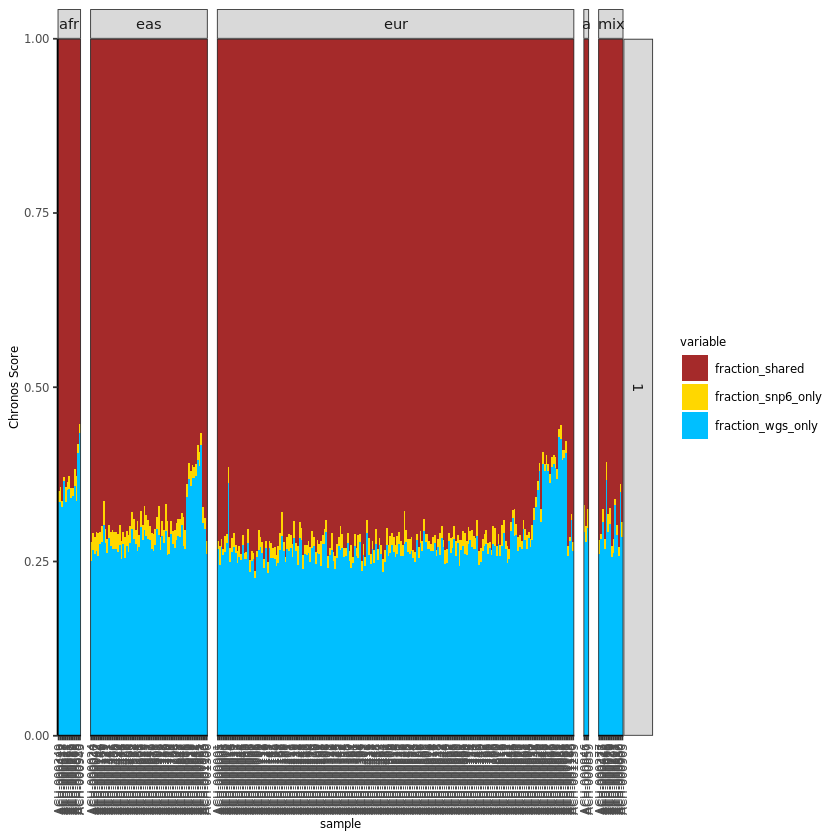

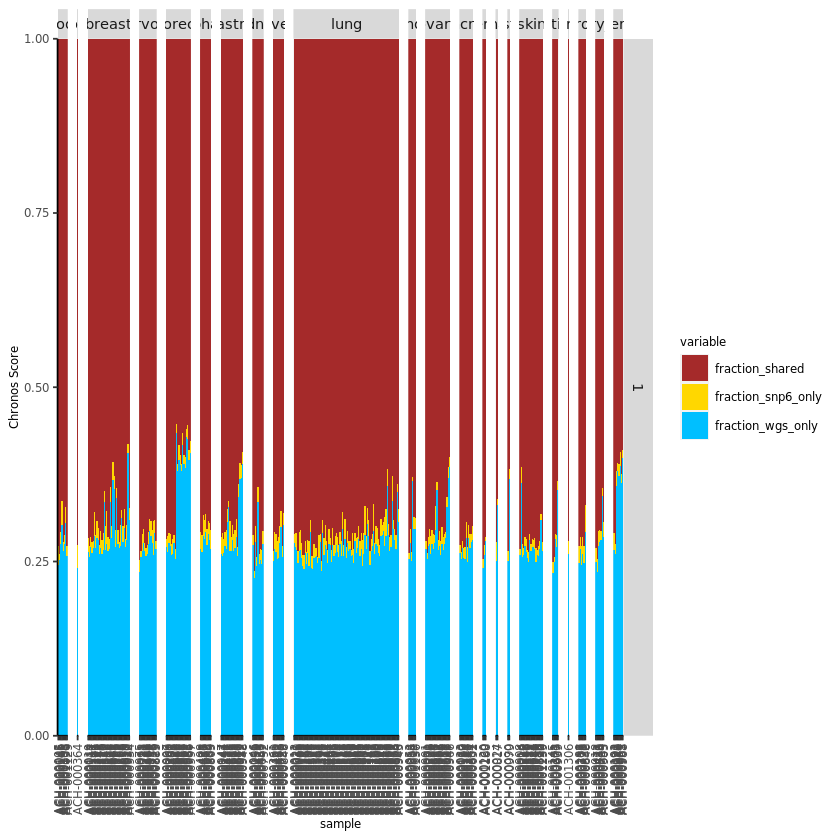

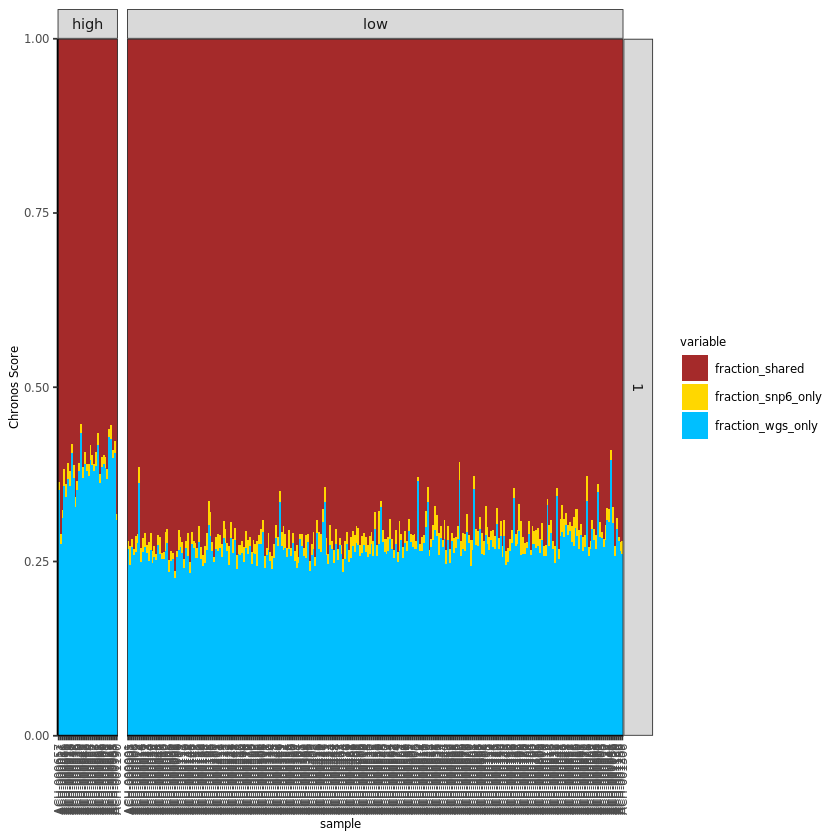

In [17]:
###plot the plots
#For ancestry
intersecting.variants.df %>%
filter(fraction_shared > 0) %>%
melt(id = c("sample", "ancestry", "lineage", "msi_status")) %>%
filter(variable %in% c("fraction_shared", "fraction_snp6_only", "fraction_wgs_only")) %>%
ggplot(aes(x = sample, y = value, fill = variable)) +
geom_bar(stat = "identity", width = 1) +
facet_grid(1 ~ ancestry, scales = "free", space='free') +
scale_fill_manual(values = c("brown", "gold", "deepskyblue")) +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

scale_y_continuous(expand = c(0, 0)) +

ylab("Chronos Score")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2')
ggsave("r2c5_ancestry_bar_plot.pdf", width = 9, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2
gsutil cp r2c5_ancestry_bar_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))






#For lineage
intersecting.variants.df %>%
filter(fraction_shared > 0) %>%
melt(id = c("sample", "ancestry", "lineage", "msi_status")) %>%
filter(variable %in% c("fraction_shared", "fraction_snp6_only", "fraction_wgs_only")) %>%
ggplot(aes(x = sample, y = value, fill = variable)) +
geom_bar(stat = "identity", width = 1) +
facet_grid(1 ~ lineage, scales = "free", space = 'free') +
scale_fill_manual(values = c("brown", "gold", "deepskyblue")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

scale_y_continuous(expand = c(0, 0)) +

ylab("Chronos Score")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2')
ggsave("r2c5_lineage_bar_plot.pdf", width = 9, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2
gsutil cp r2c5_lineage_bar_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))







#For msi status
intersecting.variants.df %>%
filter(fraction_shared > 0) %>%
melt(id = c("sample", "ancestry", "lineage", "msi_status")) %>%
filter(variable %in% c("fraction_shared", "fraction_snp6_only", "fraction_wgs_only")) %>%
ggplot(aes(x = sample, y = value, fill = variable)) +
geom_bar(stat = "identity", width = 1) +
facet_grid(1 ~ msi_status, scales = "free", space='free') +
scale_fill_manual(values = c("brown", "gold", "deepskyblue")) +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

scale_y_continuous(expand = c(0, 0)) +

ylab("Chronos Score")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2')
ggsave("r2c5_msi_bar_plot.pdf", width = 9, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2
gsutil cp r2c5_msi_bar_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))


# Comment 6

In [1]:
#Load in the pre-computed ancestry associations (with correction for lineage)
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
lm.pval.df = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = TRUE)

In [4]:
#Get a vector of ancestry-associated genes
ancestry.associated.gene.vector = lm.pval.df %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene) %>%
unique()

In [5]:
#Load in the pre-correction chronos scores
chronos.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample")
colnames(chronos.22q1) = word(colnames(chronos.22q1), 1)

head(chronos.22q1)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13022665,0.04367100,-0.01067785,-0.003038938,-0.10651800,-0.01895532,0.01761511,-0.2805246,0.011350472,⋯,-0.05643839,-0.1176586,-0.02720567,0.10508843,0.14350973,-0.10492678,0.06582083,0.161843495,0.05662022,-0.31553541
2,ACH-000004,0.08567935,-0.06229549,-0.11627584,-0.049394700,0.06851031,-0.13422925,0.15372455,-0.2020006,0.132896655,⋯,-0.10724648,-0.2477974,0.16406170,0.05887251,0.07353784,0.08136490,-0.17123188,0.150911988,0.15923277,-0.04082740
3,ACH-000005,-0.09358537,0.04150119,0.07531566,0.149414781,0.03169255,-0.23687679,0.15381363,-0.2454794,-0.115307222,⋯,-0.05148461,-0.3344562,-0.11252650,-0.02517573,-0.04089682,-0.17509416,-0.13905023,0.090325195,0.02919711,-0.02406391
4,ACH-000007,-0.03090007,-0.07052596,0.07234903,0.063206491,-0.01351520,-0.02802310,-0.02618453,-0.1836130,-0.063362284,⋯,-0.27257956,-0.4733824,0.06296188,0.18920560,0.11106164,-0.03408766,-0.17837802,-0.146564613,-0.19310283,-0.27129185
5,ACH-000009,-0.02383669,-0.05586389,0.07779927,0.084401894,0.01085966,-0.07579848,-0.01227781,-0.1429850,0.005315869,⋯,-0.18239415,-0.3284529,0.01106695,0.18831931,-0.04768609,-0.13576026,-0.28438696,-0.003517739,-0.05838324,-0.23112694
6,ACH-000011,0.08655529,-0.02187455,0.03975463,0.190257969,-0.08612250,-0.25863102,-0.05526859,-0.1497031,0.039875196,⋯,-0.64292819,-0.4389316,0.05385447,0.11210283,0.19190139,0.10649250,-0.10068460,-0.122768098,-0.12669751,-0.17658955


In [6]:
#Load in the gene block matrix that lists the ancestry for all genes and for all cell lines
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
gene.block.matrix = read.table("gene.block.matrix.txt", sep = "\t", header = T)
row.names(gene.block.matrix) = NULL

#Format gene.block.matrix so that it is ready for our analysis
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample))


head(formatted.gene.block.matrix)

,sample,TGIF1,PRDX6,CIC,PLEC,MPP2,CFTR,C1QB,ELN,SEPTIN12,⋯,GTF2H2C,TTC31,PDE8B,CHD1,PAK1,LOC284898,PRKD3,MLC1,ZBTB41,TMEM181
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000657,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ACH-000617,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,0,3
3,ACH-000685,0,0,3,0,0,0,0,0,3,⋯,0,0,0,0,0,0,0,3,0,2
4,ACH-000632,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000171,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000863,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


In [7]:
#Loop through all of the ancestry-associated genes and compute the mean dependency score for each ancestry group

mean.dependency.score.per.ancestry.df = NULL
for(i in 1:length(ancestry.associated.gene.vector)){
    
    #Get the gene of interest for this loop
    gene.of.interest = ancestry.associated.gene.vector[i] 
    
    #Get vectors that have the names of the cell lines that are of each ancestry at the 'gene.of.interest' locus
    gene.block.matrix.subset = formatted.gene.block.matrix %>% select(sample, all_of(gene.of.interest)) %>% rename("gene" = 2)
    afr.lines = gene.block.matrix.subset %>% filter(gene %in% "0") %>% pull(sample)
    amr.lines = gene.block.matrix.subset %>% filter(gene %in% "1") %>% pull(sample)
    eas.lines = gene.block.matrix.subset %>% filter(gene %in% "2") %>% pull(sample)
    eur.lines = gene.block.matrix.subset %>% filter(gene %in% "3") %>% pull(sample)
    sas.lines = gene.block.matrix.subset %>% filter(gene %in% "4") %>% pull(sample)
    
    #Subset the expression data and calculate the mean for each ancestry group
    chronos.22q1.subset = chronos.22q1 %>% select(sample, all_of(gene.of.interest)) %>% rename("gene" = 2)
    afr.mean.chronos = chronos.22q1.subset %>% filter(sample %in% all_of(afr.lines)) %>% pull(gene) %>% mean()
    amr.mean.chronos = chronos.22q1.subset %>% filter(sample %in% all_of(amr.lines)) %>% pull(gene) %>% mean()
    eas.mean.chronos = chronos.22q1.subset %>% filter(sample %in% all_of(eas.lines)) %>% pull(gene) %>% mean()
    eur.mean.chronos = chronos.22q1.subset %>% filter(sample %in% all_of(eur.lines)) %>% pull(gene) %>% mean()
    sas.mean.chronos = chronos.22q1.subset %>% filter(sample %in% all_of(sas.lines)) %>% pull(gene) %>% mean()
    
    #Create a vector with all of the information
    vector.to.add = c(gene.of.interest, afr.mean.chronos, amr.mean.chronos, eas.mean.chronos, eur.mean.chronos, sas.mean.chronos)
    
    #Add it to the data frame outside of the loop
    mean.dependency.score.per.ancestry.df = rbind(mean.dependency.score.per.ancestry.df, vector.to.add)
    
}

#Format the data frame so that it looks a bit nicer
row.names(mean.dependency.score.per.ancestry.df) = NULL
colnames(mean.dependency.score.per.ancestry.df) = c("gene", "afr", "amr", "eas", "eur", "sas")
mean.dependency.score.per.ancestry.df = mean.dependency.score.per.ancestry.df %>% 
data.frame() %>%
mutate(afr = as.numeric(afr)) %>%
mutate(amr = as.numeric(amr)) %>%
mutate(eas = as.numeric(eas)) %>%
mutate(eur = as.numeric(eur)) %>%
mutate(sas = as.numeric(sas))

In [8]:
head(mean.dependency.score.per.ancestry.df)

,gene,afr,amr,eas,eur,sas
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ABHD5,0.02890545,0.06352953,0.0199022646,0.054135126,0.08206646
2,ATOH1,-0.03888002,-0.26495214,-0.0242675007,-0.014511887,-0.01900538
3,ATP6V0E1,-0.32008308,-0.35687165,-0.2092165265,-0.147229713,-0.25434656
4,CAAP1,0.08231156,0.04796748,-0.0003528956,0.008078415,0.09811292
5,CCDC74B,-0.24285980,-0.13941624,-0.2725341513,-0.189332607,-0.22642954
6,CDKN2B,0.11659155,0.05568664,0.0598906772,0.047642669,-0.03626297


In [9]:
#Calculate the mean dependency score for all of the ancestry-associated genes 
mean.expression.df = chronos.22q1 %>%
select(all_of(ancestry.associated.gene.vector)) %>%
apply(2, mean) %>%
data.frame() %>%
rename("chronos_score" = 1) %>%
mutate("gene" = ancestry.associated.gene.vector, .before = 1)

#Get a factor order for all of the genes
gene.order = mean.expression.df %>%
arrange(chronos_score) %>%
pull(gene)

Using gene as id variables



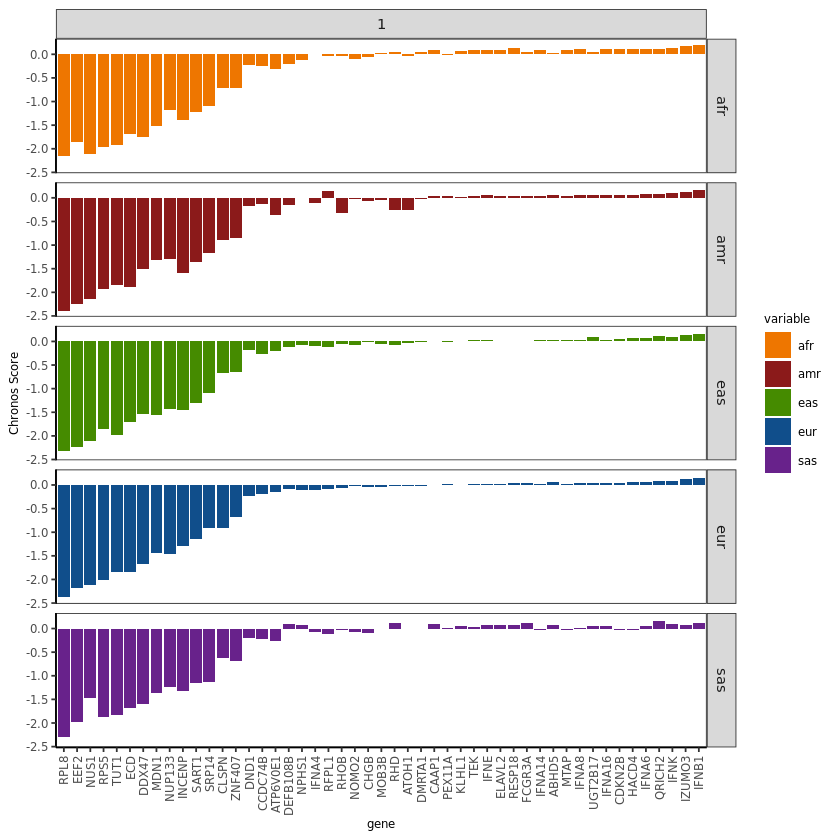

In [53]:
#Now, plot the plot
mean.dependency.score.per.ancestry.df %>% 
mutate(gene = factor(gene, levels = fct_inorder(gene.order))) %>%
melt() %>%
ggplot(aes(x = gene, y = value, fill = variable)) +
geom_bar(stat="identity") +
facet_grid(variable ~ 1) +

theme_bw() +

scale_fill_manual(values = c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

ylab("Chronos Score")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2')
ggsave("r2c6_bar_plot.pdf", width = 9, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2
gsutil cp r2c6_bar_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Plot the data in a different way

Using gene as id variables



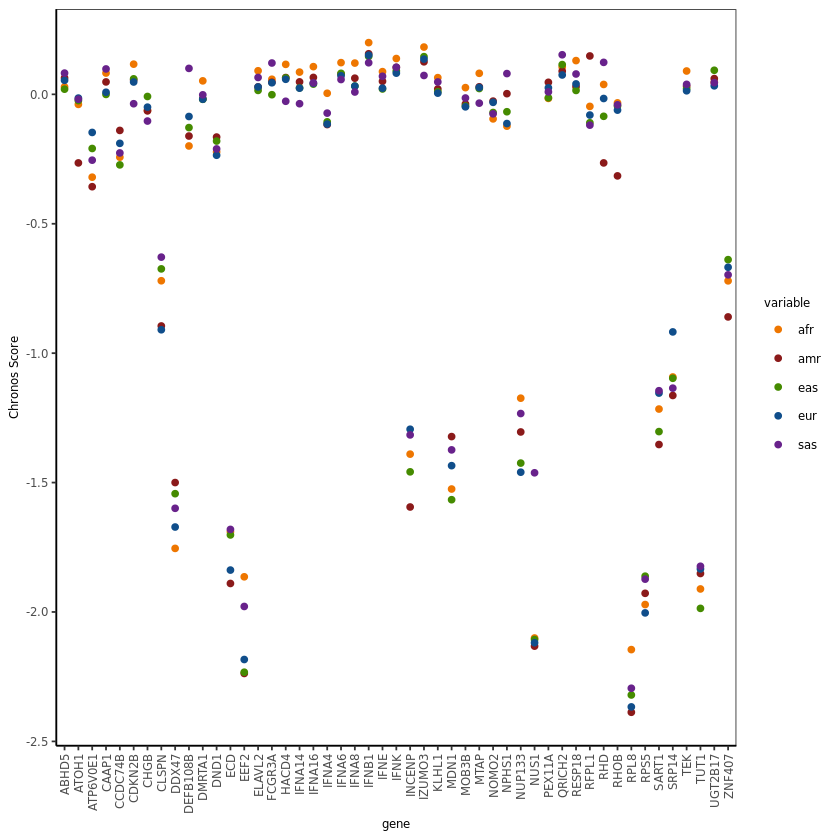

In [15]:
#Plot the plot
mean.dependency.score.per.ancestry.df %>%
melt() %>%
ggplot(aes(x = gene, y = value, fill = variable, color = variable)) +
geom_point() +

theme_bw() +

scale_fill_manual(values = c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")) +
scale_color_manual(values = c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

ylab("Chronos Score") 

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2')
ggsave("r2c6_scatter_plot.pdf", width = 9, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2
gsutil cp r2c6_scatter_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


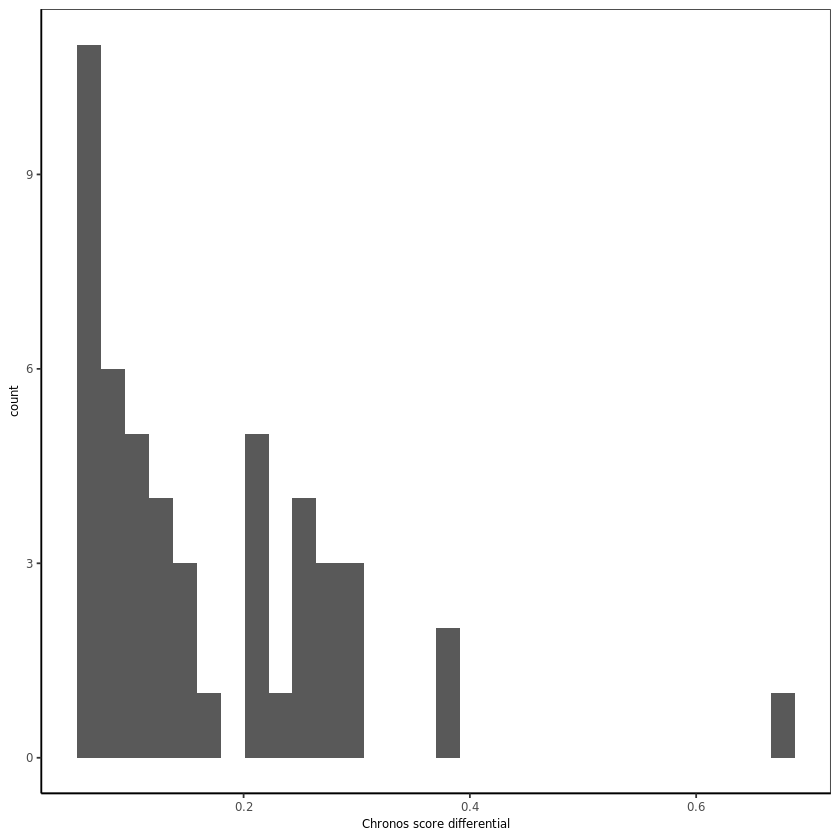

In [15]:
#Calculate the differential between the min and max, then plot a histogram.
mean.dependency.score.per.ancestry.df %>%
rowwise() %>%
mutate("minimum_score" = min(c_across(afr:sas))) %>%
rowwise() %>%
mutate("max_score" = max(c_across(afr:sas))) %>%
mutate("differential_score" = max_score - minimum_score) %>%

ggplot(aes(x = differential_score)) +
geom_histogram() +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

xlab("Chronos score differential") 

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2')
ggsave("r2c6_differential_histogram.pdf", width = 4, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2
gsutil cp r2c6_differential_histogram.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

# Comment 7

The purpose of this analysis is to make a figure demonstrating how many ancestry-associated genes have variants in the guide targeting sequences.

In [2]:
#Load in the ancestry-associated pval matrix
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/gwas_output")
all.data = read.table("merged.pvals.txt", sep = "\t", header = TRUE)

In [3]:
#FDR correct the entire dataset
all.data.fdr = all.data %>%
select(-snp) %>%
apply(2, function(x) { p.adjust(x, method = "BY", n = length(x)) }) %>%
data.frame() %>%
mutate("snp" = all.data$snp, .before = 1)

In [4]:
#Melt and subset to only include the significant SNPs
all.fdr.melted = all.data.fdr %>%
melt(id = "snp")

In [5]:
#Filter to only include significant variants
#Also split the snp column
significant.fdr = all.fdr.melted %>%
filter(value < 0.05) %>%
separate(snp, sep = ":", into = c("chr", "pos", "ref", "alt"))

In [6]:
#Load in the avana bed file
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) 

In [7]:
#Compute which SNPs intersect with a guide
in.guide.vector = significant.fdr %>%
apply(1, function(x){
    
    #Store information as variables
    chr.of.interest = x[1]
    pos.of.interest = x[2]
    
    #subset avana.bed to only include guides that target the same chromosome
    #then annotate the data frame if the variant falls within a guide
    avana.bed.filtered = avana.bed %>% 
    filter(chr %in% all_of(chr.of.interest)) %>%
    mutate("in_guide" = ifelse(pos.of.interest >= start & pos.of.interest <= end, 1, 0))
    
    #Get the guides which that snp maps to
    guide.logical = is.element(1, avana.bed.filtered$in_guide)
    
    if(guide.logical == TRUE){
        guide.to.return = avana.bed.filtered %>%
        filter(in_guide %in% "1") %>%
        pull(sgrna)
    } else {
        guide.to.return = 0
    }
    
    #Return the data outside of the loop
    return(guide.to.return) 
})

In [8]:
#Merge the guide into the main data frame
significant.fdr.with.guide = significant.fdr %>%
mutate("affected_guide" = in.guide.vector)

Load in the guide-level scores and compute the median depletion for all of the guides.

In [9]:
#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

#Get a vector of ancestry-associated genes
ancestry.associated.genes = lineage.corrected.pvals %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene) %>%
unique()

In [10]:
#Load in the data and filter it to only include ancestry-associated genes

#guide map
avana.guide.map = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='Achilles_guide_map') %>%
mutate(gene = word(gene, 1))

#guide logfc data
avana.logfc = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='Achilles_logfold_change')

#replicate map
avana.replicate.map = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='Achilles_replicate_map')

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_achilles-guide-map.rds



Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_achilles-logfold-change.rds



Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_achilles-replicate-map.rds



In [32]:
#Compute all of the ancestry-associated guides
ancestry.associated.guides = avana.guide.map %>%
filter(gene %in% all_of(ancestry.associated.genes)) %>%
pull(sgrna)

#Filter the logfc data to only include ancestry-associated guides
#Then collapse replicates into cell lines
ancestry.avana.logfc = avana.logfc %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sgrna") %>%
filter(sgrna %in% all_of(ancestry.associated.guides)) %>%
melt(id = "sgrna") %>%
mutate("sample" = plyr::mapvalues(from = avana.replicate.map$replicate_ID, to = avana.replicate.map$DepMap_ID, variable, warn_missing = FALSE)) %>%
group_by(sgrna, sample) %>%
summarise("sgrna_depletion" = mean(value)) %>%
mutate("gene" = plyr::mapvalues(from = avana.guide.map$sgrna, to = avana.guide.map$gene, sgrna, warn_missing = FALSE))


`summarise()` has grouped output by 'sgrna'. You can override using the
`.groups` argument.


In [43]:
#Get a vector of guides that have a snp
guide.with.snp = significant.fdr.with.guide %>%
filter(!affected_guide %in% "0") %>%
pull(affected_guide) %>%
unique()

#Group by guide and calculate the median across all cell lines
#Then annotate with if the guide has a snp in the targeting sequence
collapsed.median.guide.depletion = ancestry.avana.logfc %>%
group_by(sgrna) %>%
summarise("median_sgrna_depletion" = median(sgrna_depletion)) %>%
mutate("gene" = plyr::mapvalues(from = ancestry.avana.logfc$sgrna, to = ancestry.avana.logfc$gene, sgrna, warn_missing = FALSE)) %>%
mutate("snp_flag" = ifelse(sgrna %in% all_of(guide.with.snp), 1, 0))


collapsed.median.guide.depletion %>% head()

sgrna,median_sgrna_depletion,gene,snp_flag
<chr>,<dbl>,<chr>,<dbl>
AACACGCTCATCACAATGAG,-0.01137518,ATP6V0E1,0
AACTACCTATGACAGTGCCG,-0.52708524,CLSPN,0
AAGCGGAGACTGTACAGAAA,0.15173893,UGT2B17,0
AAGCTGCTCGATGAGAACAG,-1.37313856,MDN1,0
AAGGGAAGAAAATTTCCGTG,-0.03615500,RFPL1,0
AATGGACTCTGATATGGAAG,0.22496741,CAAP1,0


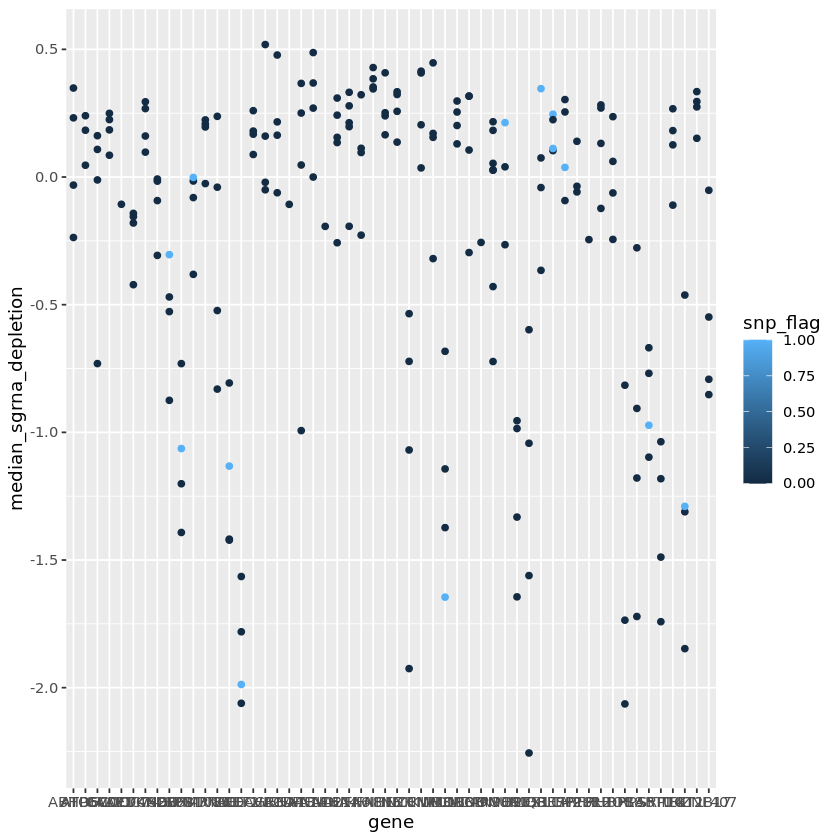

In [45]:
#Plot the plot
collapsed.median.guide.depletion %>% 
ggplot(aes(x = gene, y = median_sgrna_depletion, color = snp_flag, fill = snp_flag)) +
geom_point()

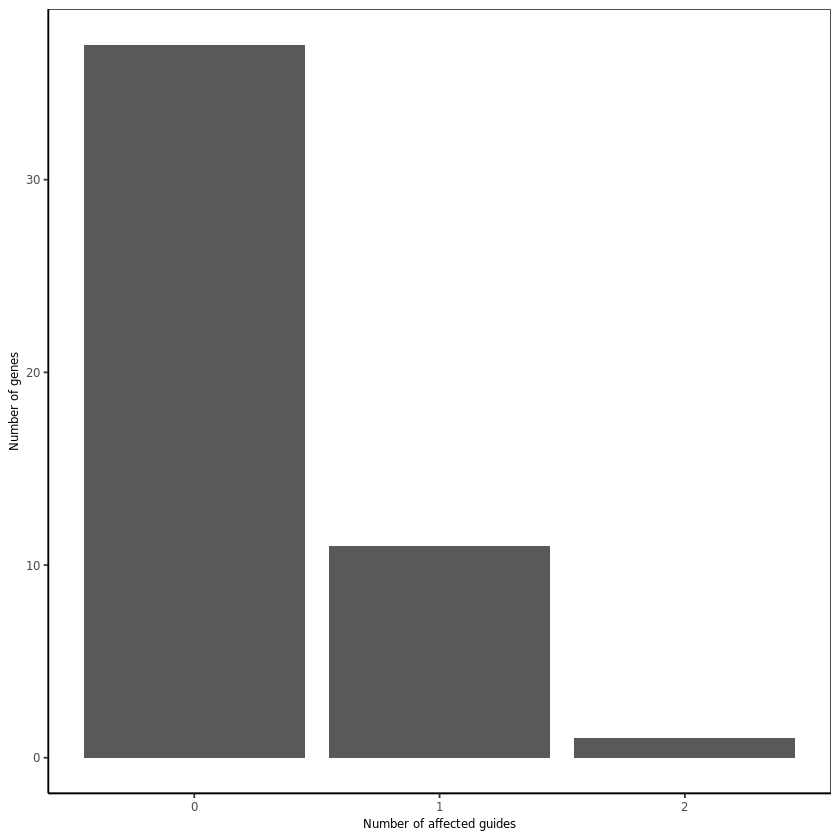

In [56]:
###Represent the data in a different way
collapsed.median.guide.depletion %>%
filter(gene %in% all_of(ancestry.associated.genes)) %>%
group_by(gene) %>%
summarise("num_affected_guides" = sum(snp_flag)) %>%
group_by(num_affected_guides) %>%
summarise("class" = n()) %>%
ggplot(aes(x = num_affected_guides, y = class)) +
geom_bar(stat = "identity") +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

ylab("Number of genes") +
xlab("Number of affected guides")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2')
ggsave("r2c7_bar_plot.pdf", width = 3, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2
gsutil cp r2c7_bar_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Re-do R2C7 with the blacklist matrix data

In [4]:
#Load in the blacklist matrix from the most recent depmap version
avana.blacklist.matrix = load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='OmicsGuideMutationsBinaryAvana')

#Load in the avana guide map from the most recent depmap version
avana.guide.map = load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='AvanaGuideMap')

Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_omicsguidemutationsbinaryavana.rds



In [5]:
avana.blacklist.matrix %>% head()

,chrom,start,end,sgRNA,ACH-000440,ACH-002947,ACH-000078,ACH-002946,ACH-001552,ACH-000392,⋯,ACH-000832,ACH-000869,ACH-000985,ACH-002245,ACH-000776,ACH-000944,ACH-000125,ACH-000564,ACH-001626,ACH-000591
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1,3757,3777,TGTAGTCCCAGCTACTCAGG,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1,4003,4023,TGCAATGGCGAGGAATACCG,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,chr1,4623,4643,GGTAGCCCTCACCCTTCCCG,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,chr1,9571,9591,TGTAGTCCCAGCTACTCAGG,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr1,18423,18443,TGTAGTCCCAGCTACTCAGG,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,chr1,18880,18900,GAGTATTCAGTGTTACCTGG,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [6]:
avana.guide.map %>% head()

ERROR: Error in head(.): object 'avana.guide.map' not found


# Comment 9

The purpose of this notebook is to do additional analysis of the gwas data from figure 2

# Comment 19

These analyses were performed in this notebook:

New_SNV_Position_Single_Guide_Association.ipynb

# Comment minor 1

This analysis was performed in the New_Affected_Guides_Per_Individual.ipynb notebook

# Comment minor 7

The purpose of this code is to do some basic analysis of the Avana And KY libraries

In [7]:
#Load in the avana guide map and the KY guide map
#Also reformat them
avana.guide.map = load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='AvanaGuideMap') %>%
rename("sgrna" = 1, "genome_alignment" = 2, "gene" = 3, "n_alignments" = 4, "drop_reason" = 5, "used_by_chronos" = 6) %>%
mutate(gene = word(gene, 1))





ky.guide.map = load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='KYGuideMap') %>%
rename("sgrna" = 1, "genome_alignment" = 2, "gene" = 3, "n_alignments" = 4, "drop_reason" = 5, "used_by_chronos" = 6) %>%
mutate(gene = word(gene, 1))

Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_avanaguidemap.rds



Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_kyguidemap.rds



In [18]:
#Calculate the number of unique genes in the KY library
ky.guide.map %>%
filter(used_by_chronos %in% "True") %>%
pull(gene) %>%
unique() %>%
length()

[1] 17349

# Comment minor 11

The purpose of this code is to create a supplemental table to address one of the reviewer's comments.

Much of this analysis was done in the 'Remake_Figures_For_Lineage_Corrected_Analysis.ipynb' notebook

In [2]:
#Load in the eqtl data
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
eqtl.summary = read.table("eqtl_summary_df.txt", sep = "\t", header = TRUE)

eqtl.summary %>% head()

,eqtl_pval,eqtl_diff_exp,gene,snp,eqtl_fdr,abs_diff_exp,sig_flag
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,3.295075e-51,-2.4822386,MTAP,chr9:21925164:A:C,7.232065e-49,2.4822386,sig
2,1.020030e-34,-1.9509119,CDKN2B,chr9:21986219:C:T,1.119386e-32,1.9509119,sig
3,2.846219e-34,-2.6020407,CAAP1,chr9:26820990:G:A,2.082304e-32,2.6020407,sig
4,2.173588e-10,-0.5907660,IFNE,chr9:21340131:A:G,1.192654e-08,0.5907660,sig
5,2.499742e-04,0.3954071,CCDC74B,chr3:70154405:A:C,1.097292e-02,0.3954071,sig
6,9.955677e-04,0.3520314,DMRTA1,chr9:22525700:G:A,3.641804e-02,0.3520314,sig


In [3]:
#Load in the dqtl data
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
top.snp.df = read.table("ancestry_top_snp_df.txt", sep = "\t", header = TRUE)

top.snp.df %>% head()

,gene,snp,pval,fdr
,<chr>,<chr>,<dbl>,<dbl>
1,ABHD5,chr19:10327278:A:G,9.99055e-08,1.000000e+00
2,ATOH1,chr6:117239254:T:C,1.85815e-26,3.064682e-18
3,ATP6V0E1,chr2:15148916:G:A,5.42604e-12,7.200293e-04
4,CAAP1,chr9:26820990:G:A,1.60688e-07,1.000000e+00
5,CCDC74B,chr3:70154405:A:C,2.08891e-07,1.000000e+00
6,CDKN2B,chr9:21986219:C:T,1.63496e-15,2.696571e-07


In [9]:
#Load in the distance to TSS data
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
distance.to.tss.df = read.table("distance_to_tss_df.txt", sep = "\t", header = TRUE)

distance.to.tss.df %>% head()
distance.to.tss.df %>% dim()

,gene,top_snp_chr,top_snp_pos,fdr,tss_chr,tss_pos,tss_strand,distance_to_tss,prox_or_dist
,<chr>,<chr>,<int>,<dbl>,<chr>,<int>,<chr>,<int>,<chr>
1,ABHD5,chr19,10327278,1.000000e+00,chr3,43690870,+,1000001,distal
2,ATOH1,chr6,117239254,3.064682e-18,chr4,93828753,+,1000001,distal
3,ATP6V0E1,chr2,15148916,7.200293e-04,chr5,172983771,+,1000001,distal
4,CAAP1,chr9,26820990,1.000000e+00,chr9,26892802,-,71812,proximal
5,CCDC74B,chr3,70154405,1.000000e+00,chr2,130145134,-,1000001,distal
6,CDKN2B,chr9,21986219,2.696571e-07,chr9,22009313,-,23094,proximal


[1] 49  9

In [16]:
#Merge everything together
merged.eqtl.dqtl.tss.df = inner_join(eqtl.summary, top.snp.df, by = "snp") %>%
data.frame() %>%
select(-gene.x, -abs_diff_exp, -sig_flag) %>%
rename("dqtl_pval" = pval, "dqtl_fdr" = fdr, "gene" = gene.y) %>%
inner_join(distance.to.tss.df, by = "gene") %>%
select(-eqtl_diff_exp, -top_snp_chr, -tss_pos, -tss_chr, -tss_strand, -distance_to_tss, -fdr) %>%
relocate(gene, .before = 1) %>%
relocate(snp, .after = gene) %>%
relocate(eqtl_pval, .after = snp) %>%
relocate(eqtl_fdr, .after = eqtl_pval) %>%
relocate(dqtl_pval, .after = eqtl_fdr) %>%
relocate(dqtl_fdr, .after = dqtl_pval) %>%
select(-top_snp_pos) %>%
rename("prox_or_dist_to_tss" = prox_or_dist)



merged.eqtl.dqtl.tss.df %>% head()

,gene,snp,eqtl_pval,eqtl_fdr,dqtl_pval,dqtl_fdr,prox_or_dist_to_tss
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,MTAP,chr9:21925164:A:C,3.295075e-51,7.232065e-49,4.14323e-08,1.000000e+00,proximal
2,CDKN2B,chr9:21986219:C:T,1.020030e-34,1.119386e-32,1.63496e-15,2.696571e-07,proximal
3,CAAP1,chr9:26820990:G:A,2.846219e-34,2.082304e-32,1.60688e-07,1.000000e+00,proximal
4,IFNA14,chr9:21340131:A:G,2.173588e-10,1.192654e-08,5.72238e-09,5.345468e-01,proximal
5,IFNA4,chr9:21340131:A:G,2.173588e-10,1.192654e-08,3.63800e-08,1.000000e+00,proximal
6,IFNE,chr9:21340131:A:G,2.173588e-10,1.192654e-08,5.93298e-13,9.785378e-05,proximal


In [19]:
#Export the data frame
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
write.table(merged.eqtl.dqtl.tss.df, "merged_eqtl_dqtl_tss.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp merged_eqtl_dqtl_tss.txt gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

# Comment minor 16

In [32]:
#Load in the avana bed file
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) 

total.avana.guides = avana.bed %>% pull(sgrna) %>% unique() %>% length()

In [11]:
#Create a special bed file for filtering SNPs
avana.bed.for.filtering = avana.bed %>%
mutate(start = start - 10, .after = start) %>%
mutate(end = end + 10, .after = end)

#Write the bed file
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2")
write.table(avana.bed.for.filtering, "avana_filtering_bed_file.bed", sep = "\t", col.names = FALSE, row.names = FALSE, quote = FALSE)

In [12]:
#Filter the CCLE variants so that it only includes variants that fall within those guides
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2
/home/jupyter/Ancestry/software/bcftools/bcftools filter -R /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2/avana_filtering_bed_file.bed /home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/split.all_chroms.maf.subset.reheader.vcf.gz -O z -o avana.filtered.ccle.variant.calls.vcf.gz 
"))

In [ ]:
#Get the sample names from the original vcf file
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2
/home/jupyter/Ancestry/software/bcftools/bcftools query -l /home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/split.all_chroms.maf.subset.reheader.vcf.gz > 

"))

In [3]:
#Load in the variant calls
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2")
all.ccle.variant.calls = read.table("avana.filtered.ccle.variant.calls.vcf.gz", sep = "\t")


#Load in the sample names
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2")
ccle.sample.names = read.table("ccle.sample.headers.txt", sep = "\t") %>%
pull(V1)


#Build a nice-looking dataset
formatted.avana.ccle.variant.calls = all.ccle.variant.calls %>%
rename("snp" = 2, "qual" = 7) %>%
filter(qual %in% "PASS") %>%
select(-1, -2, -4, -5, -6, -qual, -8, -9)

colnames(formatted.avana.ccle.variant.calls) = c("snp", ccle.sample.names)


#Melt the dataset and re-format the variant call encoding
melted.avana.ccle.variant.calls = formatted.avana.ccle.variant.calls %>%
melt(id = "snp") %>%
mutate(value = gsub(":.*", "", value)) %>%
mutate(value = gsub("0\\|0", "0", value)) %>%
mutate(value = gsub("0\\|1", "1", value)) %>%
mutate(value = gsub("1\\|0", "1", value)) %>%
mutate(value = gsub("1\\|1", "2", value)) %>%
rename("sample" = 2, "status" = 3) %>%
separate(snp, sep = ":", into = c("chr", "pos", "ref", "alt")) %>%
select(-ref, -alt) %>%
mutate("snp" = paste(chr, ":", pos, sep = ""), .before = 1)



melted.avana.ccle.variant.calls %>% head()

,snp,chr,pos,sample,status
,<chr>,<chr>,<chr>,<fct>,<chr>
1,chr1:970892,chr1,970892,ACH-000657,1
2,chr1:1399095,chr1,1399095,ACH-000657,0
3,chr1:1407014,chr1,1407014,ACH-000657,0
4,chr1:1426150,chr1,1426150,ACH-000657,0
5,chr1:1426175,chr1,1426175,ACH-000657,1
6,chr1:1426356,chr1,1426356,ACH-000657,0


In [4]:
#Create a megabed that has all possible guide positions
avana.megabed = avana.bed %>% 
apply(1, function(x){
    
    #define some variables
    chr.of.interest = x[1]
    start.pos.of.interest = x[2]
    end.pos.of.interest = x[3]
    sgrna.of.interest = x[4]
    
    #build some vectors
    sequence.vector = seq(from = start.pos.of.interest, to = end.pos.of.interest, by = 1)
    chr.vector = rep(chr.of.interest, length(sequence.vector))
    sgrna.vector = rep(sgrna.of.interest, length(sequence.vector))
    
    #assemble the dataframe
    df.to.export = cbind(chr.vector, sequence.vector, sgrna.vector) %>% data.frame()
    
    #export the data frame
    return(df.to.export)
    
}) %>%
do.call(rbind, .) %>%
rename("chr" = 1, "pos" = 2, "sgrna" = 3) %>%
mutate("snp" = paste(chr, ":", pos, sep = ""), .before = chr)



In [12]:
#Annotate melted.avana.ccle.variant.calls so that is has the affected guide
annotated.avana.ccle.variant.calls = melted.avana.ccle.variant.calls %>%
rename("snp_status" = status) %>%
mutate("affected_sgrna" = plyr::mapvalues(from = avana.megabed$snp, to = avana.megabed$sgrna, snp, warn_missing = FALSE)) %>%
filter(!grepl('chr', affected_sgrna)) %>%
mutate(snp_status = as.numeric(snp_status))


In [17]:
#Load in the pre-correction chronos scores
chronos.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample")
colnames(chronos.22q1) = word(colnames(chronos.22q1), 1)

#Get a vector of samples in this dataset
chronos.22q1.samples = chronos.22q1 %>% pull(sample)

#Get vector of snp6 samples
snp6.samples = melted.avana.ccle.variant.calls %>% pull(sample) %>% unique()

#Get a vector of intersecting samples between chronos and snp6
samples.to.keep = intersect(chronos.22q1.samples, snp6.samples)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



In [34]:
#Calculate the total number of affected guides
total.affected.guides = annotated.avana.ccle.variant.calls %>%
filter(snp_status >= 1) %>%
filter(sample %in% all_of(samples.to.keep)) %>%
pull(affected_sgrna) %>%
unique() %>%
length()

print(paste("The total number of affected guides is:", total.affected.guides))



#Calculate the total number of guides that are affected in at least 10 cell lines
total.affected.in.10.lines = annotated.avana.ccle.variant.calls %>%
filter(snp_status >= 1) %>%
filter(sample %in% all_of(samples.to.keep)) %>%
group_by(affected_sgrna) %>%
summarize("unique_count" = n_distinct(sample)) %>%
filter(unique_count >= 10) %>%
pull(affected_sgrna) %>%
unique() %>%
length()

print(paste("The total number of guides affected in at least 10 cell lines is:", total.affected.in.10.lines))



#Calculate the percent of guides that are affected
percent.of.guides.affected = (total.affected.guides/total.avana.guides)*100

print(paste(percent.of.guides.affected, "% of guides are affected in at least one cell line.", sep = ""))



#calculate the precent of guides that are affected in at least 10 cell lines
percent.of.guides.affected.in.10.lines = (total.affected.in.10.lines/total.avana.guides)*100

print(paste(percent.of.guides.affected.in.10.lines, "% of guides are affected in at least one cell line.", sep = ""))

[1] "The total number of affected guides is: 3368"
[1] "The total number of guides affected in at least 10 cell lines is: 3209"
[1] "4.57627348940854% of guides are affected in at least one cell line."
[1] "4.36023207467696% of guides are affected in at least one cell line."


In [36]:
#Load in the single-guide p-value matrix
setwd("/home/jupyter/Ancestry/analysis/snv_position_single_guide")
single.guide.pval.matrix = read.table("snv_position_single_guide_finaldf.txt", sep = "\t", header = T) %>%
mutate(position = factor(position, levels = 0:22))

#Get a vector with all of the guides that have a significant association
all.significant.guides = single.guide.pval.matrix %>%
filter(fdr <= 0.05) %>%
pull(sgrna) %>%
unique()

In [48]:
#Get a vector that contains the guides that are affected in at least 10 cell lines
guides.affected.in.10.lines = annotated.avana.ccle.variant.calls %>%
filter(snp_status >= 1) %>%
filter(sample %in% all_of(samples.to.keep)) %>%
group_by(affected_sgrna) %>%
summarize("unique_count" = n_distinct(sample)) %>%
filter(unique_count >= 10) %>%
pull(affected_sgrna) %>%
unique()


#Of the guides with a SNP, calculate how many are also significant
number.affected.and.significant = setdiff(guides.affected.in.10.lines, all.significant.guides) %>% length()

percent.affected.and.significant = (number.affected.and.significant/total.affected.in.10.lines)*100

print(paste("the percent of guides that are affected by a snp in 10 lines and have a significant association with guide dependency score is:", percent.affected.and.significant))



#Of the above guides, what fraction of DepMap do they make up?
fraction.of.depmap = (number.affected.and.significant/total.avana.guides)*100

print(paste("the fraction of depmap that is affected is:", fraction.of.depmap))

[1] "the percent of guides that are affected by a snp in 10 lines and have a significant association with guide dependency score is: 56.2168899968838"
[1] "the fraction of depmap that is affected is: 2.45118686902999"


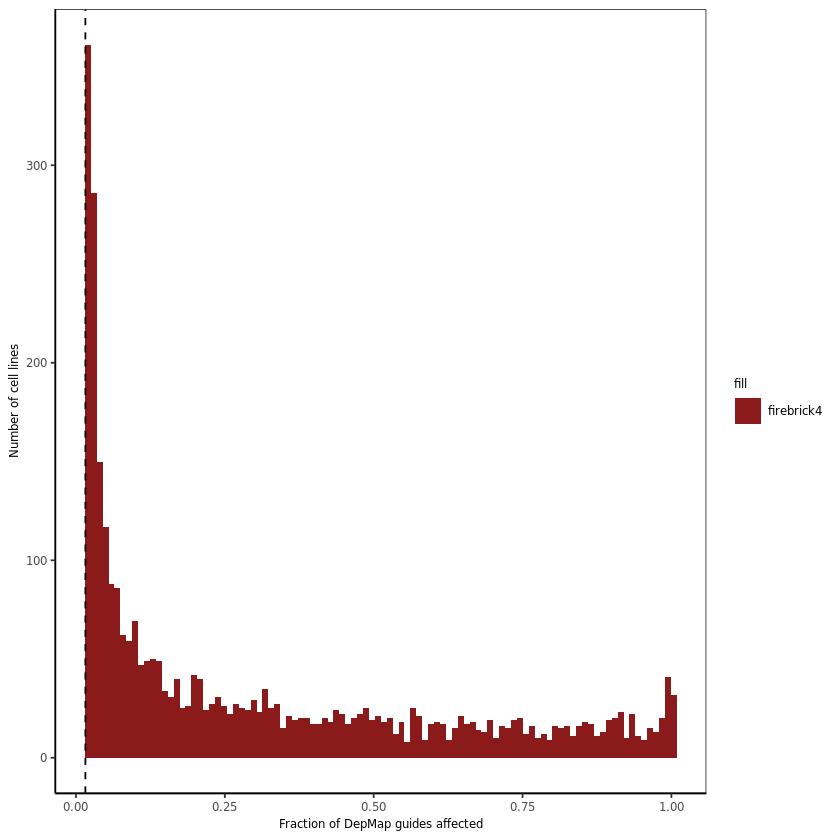

In [75]:
#Create a new distribution plot
df.for.distribution.plot = annotated.avana.ccle.variant.calls %>%
filter(snp_status >= 1) %>%
filter(sample %in% all_of(samples.to.keep)) %>%
group_by(affected_sgrna) %>%
summarize("unique_count" = n_distinct(sample)) %>%
mutate("fraction_affected" = unique_count/length(samples.to.keep))


#Plot the plot
df.for.distribution.plot %>%
filter(unique_count >= 10) %>%
ggplot(aes(x = fraction_affected, fill = "firebrick4")) +
geom_histogram(bins = 100) +

geom_vline(xintercept = 10/length(samples.to.keep), linetype = 2) +

theme_bw() +

scale_fill_manual(values = "firebrick4") +


theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +


theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

ylab("Number of cell lines") +
xlab("Fraction of DepMap guides affected")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2')
ggsave("r2mc16_histogram.pdf", width = 4, height = 2)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_2
gsutil cp r2mc16_histogram.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))
